# Regression based anomaly detection

Name: Benjamin Fraeyman

In [1]:
# ![My Title](https://www.popsci.com/sites/popsci.com/files/styles/1000_1x_/public/images/2018/03/windmills-2263325_1920.jpg?itok=HiFGIhYP&fc=50,50)

Within this exercise our goal is to detect anomalies in the behaviour of wind turbines.

Wind turbines are machines that convert the energy in the wind into electrical energy. This is an input output behavior we will imitate using machine learning. Our machine learning algorithm will predict how much energy a wind turbine should generate given input parameters such as the wind speed, the wind direction, the air temperature and so on.

The machine learning model will be trained using data from a healthy wind turbine. This means that our machine learning algorithm will be able to imitate this normal behaviour. As a result, if the turbine is malfunctioning and it produces too little electricity at a certain wind speed and other parameters, it will not produce the amount of energy the machine learning model will predict. Hence, there will be a difference between the output of the machine learning model and the actual output of the wind turbine. 

Concretely, to detect anomalies in wind turbine behavior we will do the following:

1. Create a multivariate regression model that takes the wind speed, wind direction, temperature, yaw and pitch as input and predicts the electrical output the wind turbine should generate.
2. Train this model on the training set.
3. Given the environmental parameters, predict the expected output power on the testing set.
4. Calculate the residual (the difference between the measured output power and the actual output power).
5. Determine the standard deviation and the mean.
6. On the holdout set, create a check to see if the residuals of the holdout set are inliers or outlier using the 3 sigma rule. 3 sigma rule:

![My Title](inlier_outlier.png)

sigma = standard deviation

Using this rule about 99.7% of the data shoud be inliner:

![My Title](https://upload.wikimedia.org/wikipedia/commons/thumb/2/22/Empirical_rule_histogram.svg/450px-Empirical_rule_histogram.svg.png)

The approach summarized:

![My Title](dia.png)

---

imports

In [2]:
import pandas as pd
import matplotlib.pylab as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from typing import Set, Any
def remove_others(df, columns: Set[Any]):
    cols_total: Set[Any] = set(df.columns)
    diff: Set[Any] = cols_total - columns
    df.drop(diff, axis=1, inplace=True)
    return df

C:\ProgramData\Anaconda2\envs\pyth36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


---

**Load the training (training.csv), testing (testing.csv) and hold out set (hold_out.csv).**

This data originates from the Engie wind farm in France: https://opendata-renewables.engie.com/pages/home/

The hold out set contains anomalies we want to detect.

In [3]:
df_training = pd.read_csv('./training.csv', sep=",")
df_testing = pd.read_csv('./testing.csv', sep=",")
df_holdout = pd.read_csv('./hold_out.csv', sep=",")

---

**(1) Inspect the dataframe to see which columns are present in these datasets**

In [4]:
display(df_training.head(1))
display(df_testing.head(1))
display(df_holdout.head(1))

,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2015-01-01 00:00:00,6.35,5.42,7.42,0.35,283.31,30.139999,-0.99,30.139999,0.77,46.549999


,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2016-01-01 00:00:00,6.14,4.32,8.41,0.74,397.35001,214.7,-0.99,214.7,5.55,211.83


,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2016-12-01 00:00:00,4.4,3.52,5.48,0.33,84.339996,284.70999,-0.99,284.70999,3.5,280.98001


**(2) convert the 'Date_time' column to datetime**

In [5]:
df_training['Date_time'] = pd.to_datetime(df_training['Date_time'])
df_testing['Date_time'] = pd.to_datetime(df_testing['Date_time'])
df_holdout['Date_time'] = pd.to_datetime(df_holdout['Date_time'])
# df_training['datetime'] = df_training['Date_time']
# df_training = df_training.drop(columns=['Date_time'])
# df_testing['datetime'] = df_testing['Date_time']
# df_testing = df_testing.drop(columns=['Date_time'])
# df_holdout['datetime'] = df_holdout['Date_time']
# df_holdout = df_holdout.drop(columns=['Date_time'])
display(df_training.head(1))
display(df_testing.head(1))
display(df_holdout.head(1))

,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2015-01-01,6.35,5.42,7.42,0.35,283.31,30.139999,-0.99,30.139999,0.77,46.549999


,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2016-01-01,6.14,4.32,8.41,0.74,397.35001,214.7,-0.99,214.7,5.55,211.83


,Date_time,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
0,2016-12-01,4.4,3.52,5.48,0.33,84.339996,284.70999,-0.99,284.70999,3.5,280.98001


**(3) set the 'Date_time' column as the index of the dataframes**

In [6]:
df_training.set_index('Date_time', inplace=True, drop=True)
df_testing.set_index('Date_time', inplace=True, drop=True)
df_holdout.set_index('Date_time', inplace=True, drop=True)
display(df_training.head(1))
display(df_testing.head(1))
display(df_holdout.head(1))

,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
Date_time,,,,,,,,,,
2015-01-01,6.35,5.42,7.42,0.35,283.31,30.139999,-0.99,30.139999,0.77,46.549999


,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
Date_time,,,,,,,,,,
2016-01-01,6.14,4.32,8.41,0.74,397.35001,214.7,-0.99,214.7,5.55,211.83


,Ws_avg,Ws_min,Ws_max,Ws_std,P_avg,Wa_c_avg,Ba_avg,Na_c_avg,Ot_avg,Ya_avg
Date_time,,,,,,,,,,
2016-12-01,4.4,3.52,5.48,0.33,84.339996,284.70999,-0.99,284.70999,3.5,280.98001


---

Some info in the variables in the dataset:

- Date_time: the date and time
- Ws_avg: the average wind speed in the last 10 minutes
- Ws_min: the minimum wind speed in the last 10 minutes
- Ws_max: the maximum wind speed in the last 10 minutes
- Ws_std: the standard deviation in the last 10 minutes
- P_avg: the average produced electrical power in the last 10 minutes (this will be the variable we want to predict)
- Wa_c_avg: the absolute wind direction average of the last 10 minutes
- Ba_avg: the average pitch angle of the wind turbine in the last 10 minutes
- Na_c_avg: the average nacelle angle of the wind turbine in the last 10 minutes
- Ot_avg: the average temperature outside of the wind turbine in the last 10 minutes
- Ya_avg: the average yaw angle of the wind turbine in the last 10 minutes

---

**Plot the windspeed versus the power output of the wind turbine for the training set (x-axis = wind speed, y-axis = power) using a scatter plot, make sure to set the alpha value to 0.1 so you can see the density of the plot.**

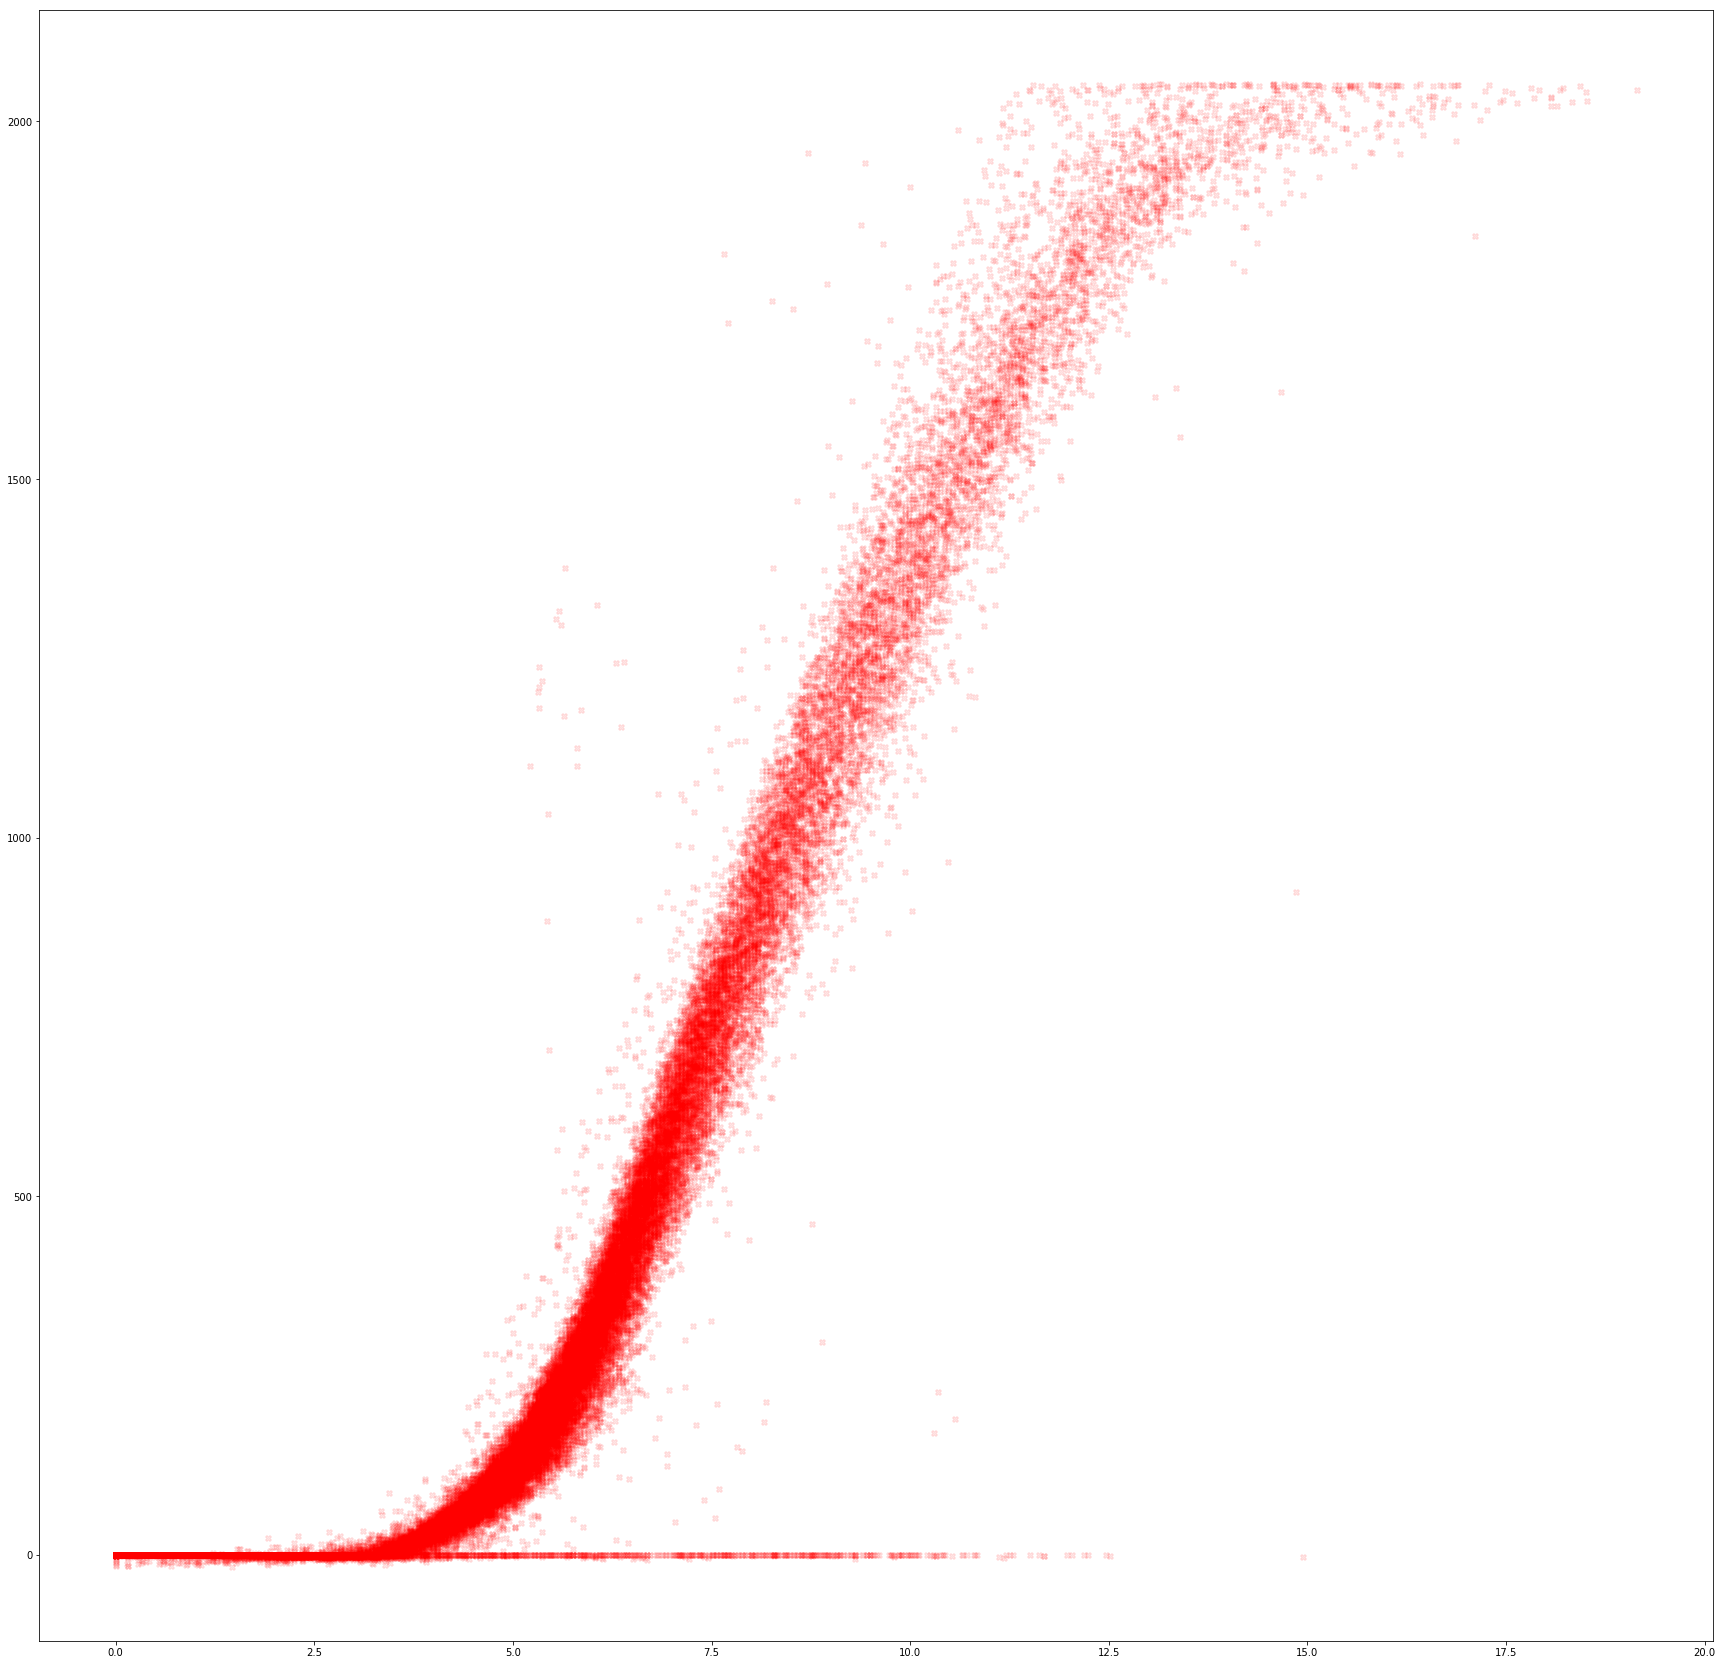

In [7]:
fig = plt.figure(figsize=(30,30))
plt.scatter(df_training['Ws_avg'], df_training['P_avg'], marker= "X", c="red", alpha = 0.1)
plt.show()

---

At this point we are ready to train a machine learning model. To do this, we first need to:

**(1) create a training set and the corresponding labels (X_train, and y_train).** 

X_train should contain all the variables except for the date_time and P_avg. y_train should contain only P_avg.

In [8]:
# msk = np.random.rand(len(df_training)) < 0.8
# X_train = df_training[msk]
# X_test = df_training[~msk]

X_train = df_training.drop(columns=['P_avg'])
y_train = remove_others(df_training, {"P_avg"})

**(2) Do the same for df_testing and create X_test and y_test.**

In [9]:
X_test = df_testing.drop(columns=['P_avg'])
y_test = remove_others(df_testing, {"P_avg"})

---

**Using Scikit-learn, create a `RandomForestRegressor` that uses 250 trees.**

In [10]:
clf = RandomForestRegressor(n_estimators=250, random_state=0)

**fit it on the training set:**

In [11]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

---

Using the trained random forest:

**(1) make a prediction for the training set**

In [12]:
prediction_Xtrain = clf.predict(X_train)
prediction_Xtrain

array([289.5133204 , 270.12008064, 237.12052004, ..., 421.69871412,
       410.83956064, 374.29167308])

**(2) calculate the r2_score**

In [13]:
r2_score(y_train, prediction_Xtrain)

0.9990638350667218

**(3) mean squared error**

In [14]:
mean_squared_error(y_train, prediction_Xtrain)

239.23923653802288

**(4) plot the predictions versus the labels in a scatter plot (alpha = 0.1, marker='.')**

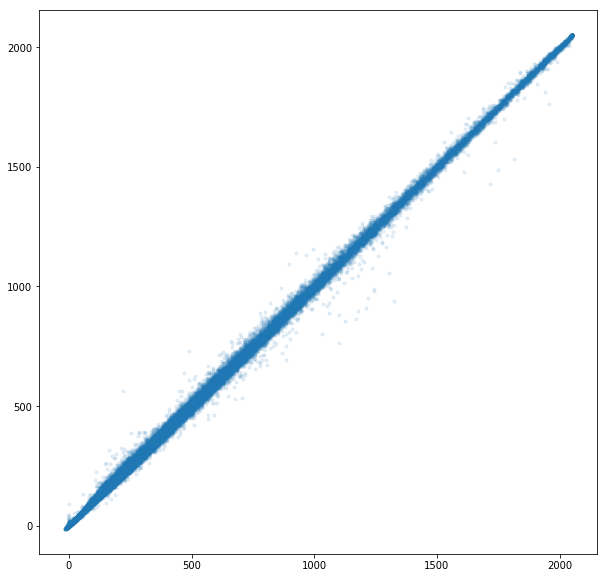

In [15]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_train, prediction_Xtrain, marker= ".", alpha = 0.1)
plt.show()

---

Also:

**(1) make a prediction for the test set**

In [16]:
prediction_Xtest = clf.predict(X_test)
prediction_Xtest

array([380.9877616 , 264.77536016, 261.61208016, ...,  75.16008012,
        78.04995973,  76.26680003])

**(2) calculate the r2_score**

In [17]:
r2_score(y_test, prediction_Xtest)

0.9903963821470503

**(3) mean squared error**

In [18]:
mean_squared_error(y_test, prediction_Xtest)

1967.988282561706

**(4) plot the predictions versus the labels in a scatter plot (alpha = 0.1, marker='.')**

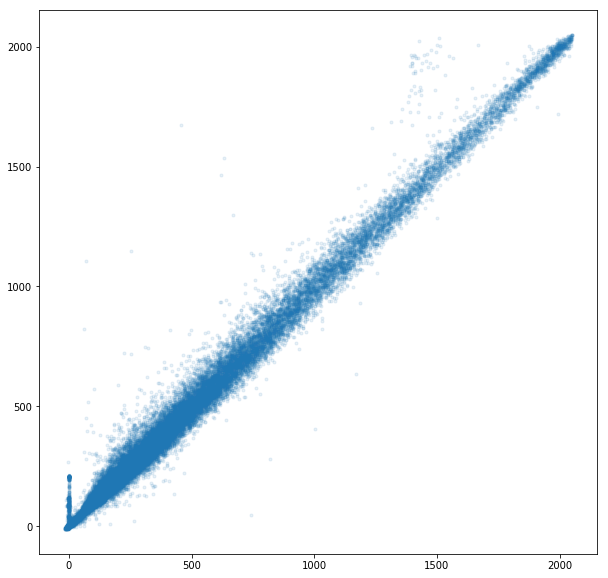

In [19]:
fig = plt.figure(figsize=(10,10))
plt.scatter(y_test, prediction_Xtest, marker= ".", alpha = 0.1)
plt.show()

---

Using the predictions on the testing set calculate:

**(1) the residuals (predictions - ground truth)**

In [20]:
residual = np.subtract(prediction_Xtest, y_test['P_avg'].values)
residual

array([-16.3622484 , -36.57464984, -36.63791984, ..., -17.88992288,
       -16.00004327,  -3.19319897])

**(2) the mean of the residuals**

In [21]:
mean_residual = np.mean(residual)
mean_residual

3.9078053818635166

**(3) the standard deviation of the residuals**

In [22]:
stand_dev_residuals = np.std(residual)
stand_dev_residuals

44.1895614332071

---

Use your random forest model to predict the expected power output for the hold-out set, similar to what you have done for the testing set:

In [23]:
X_holdout = df_holdout.drop(columns=['P_avg'])
y_holdout = remove_others(df_holdout, {"P_avg"})

prediction_Xholdout = clf.predict(X_holdout)
prediction_Xholdout

array([77.47783989, 82.32643975, 82.81980028, ..., 17.2355199 ,
       50.79147997, 99.08991976])

**Using the 3 sigma rule (and the calculated mean and standard deviation), detect the anomalies in the hold-out set.** 

In [24]:
anomalies = []
for i in prediction_Xholdout:
    if ((mean_residual + 3*stand_dev_residuals) <= i) or ((mean_residual - 3*stand_dev_residuals) >= i):
        anomalies.append(i)

**Calculate the percentage of samples that can be considered anomalies. Make sure you display this number.**

In [25]:
p_anomalies = len(anomalies)/len(prediction_Xholdout)
print("Percentage of samples that can be considered anomalies:", "%.2f" % (p_anomalies*100), "%")

Percentage of samples that can be considered anomalies: 53.21 %


---

**(1) Make a plot displaying the residuals of the holdout set.**

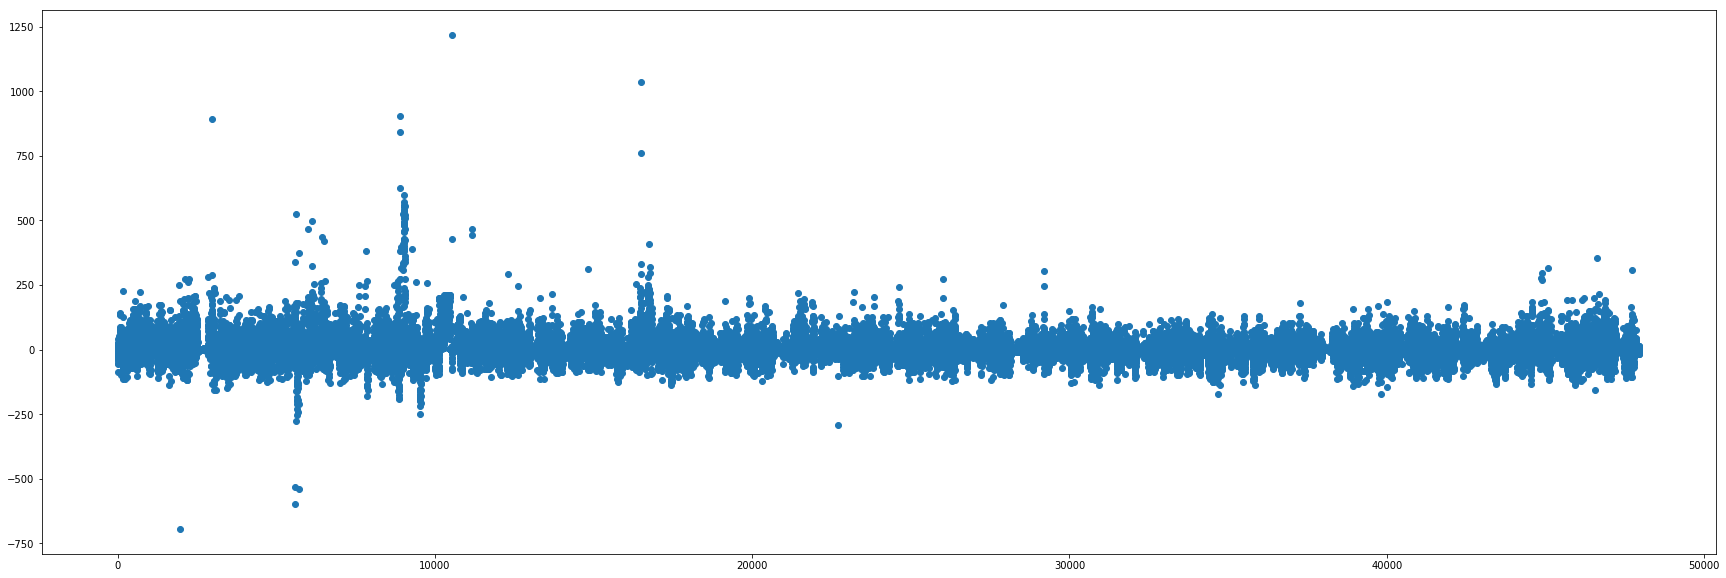

In [26]:
lower_bound = (mean_residual - 3*stand_dev_residuals)
upper_bound = (mean_residual + 3*stand_dev_residuals)
x = np.arange(0, len(residual), 1)

fig, ax = plt.subplots(1, figsize=(30,10))
plt.scatter(x, residual)
plt.show()

**(2) on the same plot, display the 3 sigma interval using "fill_between" of matplotlib.**

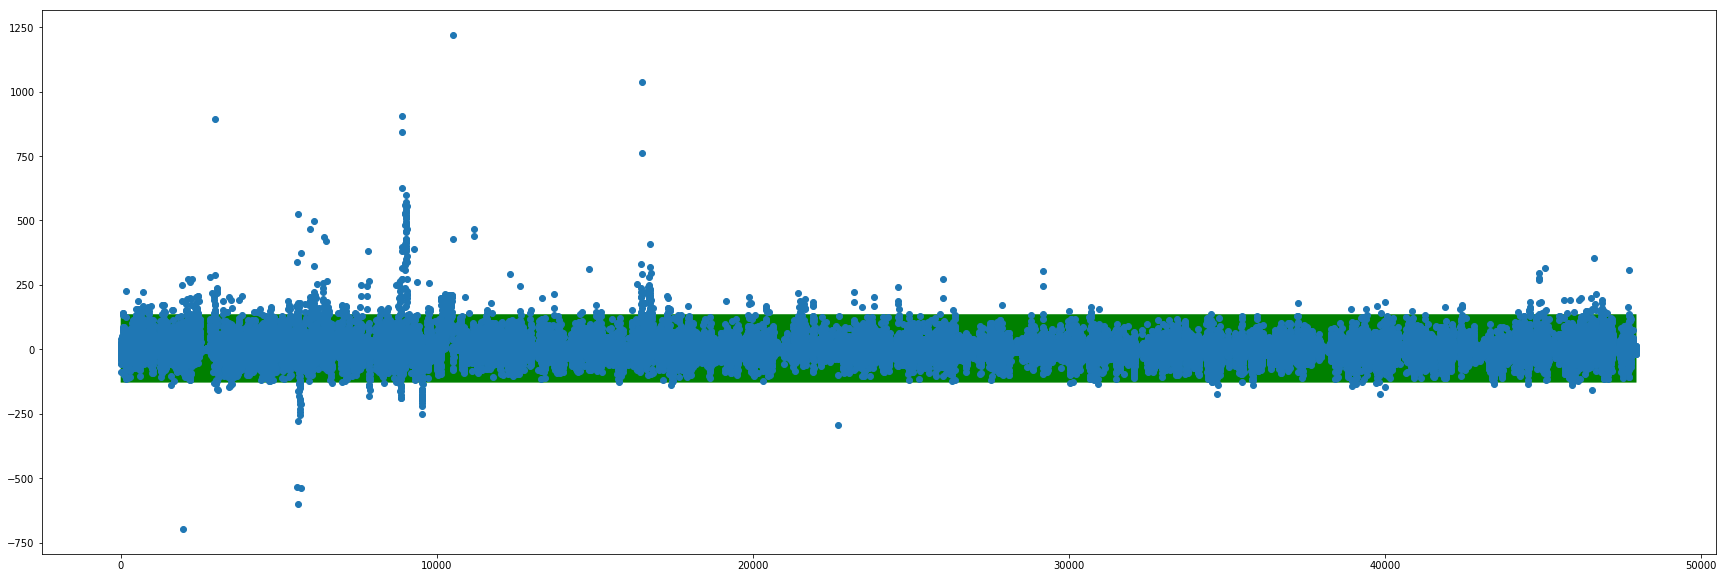

In [27]:
fig, ax = plt.subplots(1, figsize=(30,10))
ax.fill_between(x, lower_bound, upper_bound, facecolor='green', alpha=1)
plt.scatter(x, residual)
plt.show()

**(3) make sure that all the points within the 3 sigma range are given 1 color and those outside this range should have another color.**

> I was unable to get this to work, how is this done?

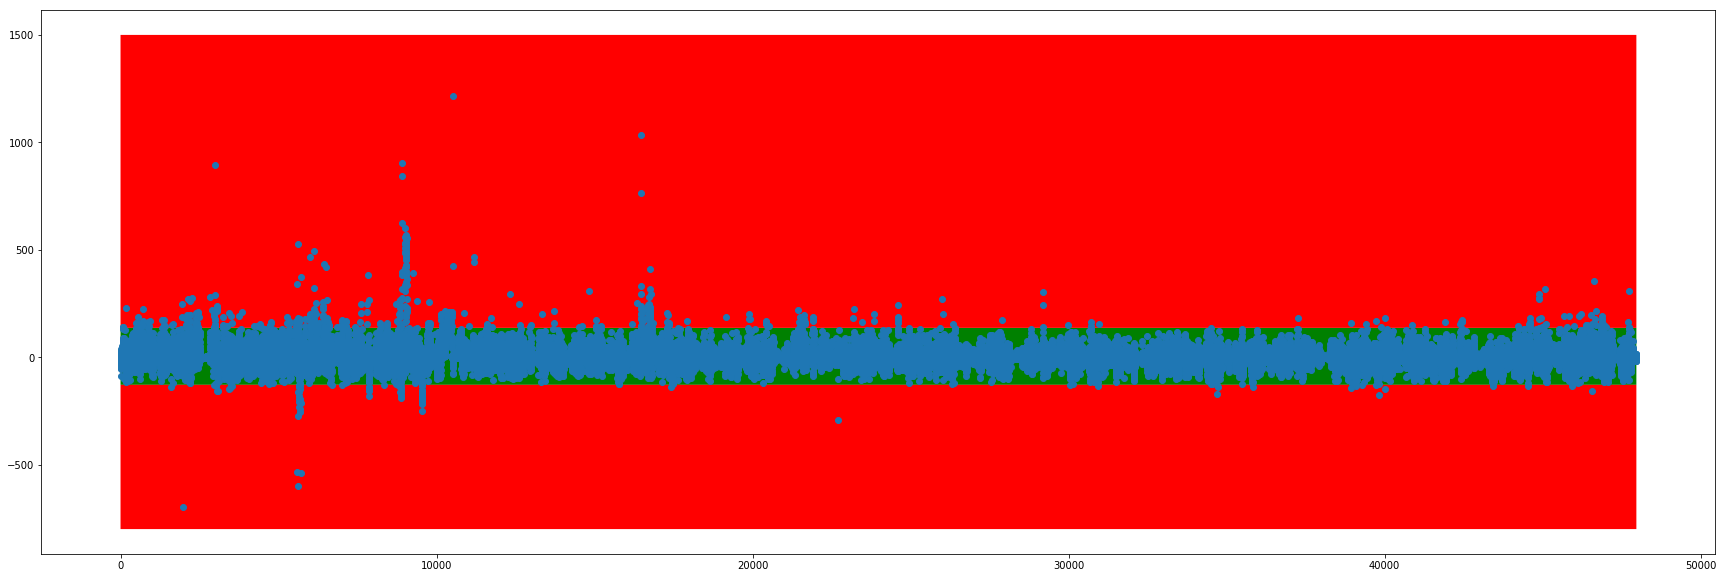

In [28]:
fig, ax = plt.subplots(1, figsize=(30,10))
ax.fill_between(x, lower_bound, upper_bound, facecolor='green', alpha=1)
ax.fill_between(x, upper_bound, 1500, facecolor='red')
ax.fill_between(x, lower_bound, -800, facecolor='red')
plt.scatter(x, residual)
plt.show()

---

**On which day (year, month & day) did the most number of anomalies occur?** 

Determine this using pandas

In [29]:
anom = df_training.iloc[anomalies]
days = anom.index.day.value_counts().first_valid_index()
day = anom.loc[anom.index.day == days].index[0]
print(day.year,"/", day.month,"/", day.day)

2015 / 1 / 2
